# Customer Revenue Prediction

The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.
This notebook will analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset from Kaggle competition ['Google Analytics Customer Revenue Prediction'](https://www.kaggle.com/c/ga-customer-revenue-prediction) to predict revenue per customer. 

### About the dataset:

Each row in the dataset is one visit to the store. Targeted outputs are prediction of the natural log of the sum of all transactions per user.

The data fields in the given files are

* fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
* channelGrouping - The channel via which the user came to the Store.
* date - The date on which the user visited the Store.
* device - The specifications for the device used to access the Store.
* geoNetwork - This section contains information about the geography of the user.
* sessionId - A unique identifier for this visit to the store.
* socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
* totals - This section contains aggregate values across the session.
* trafficSource - This section contains information about the Traffic Source from which the session originated.
* visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
* visitNumber - The session number for this user. If this is the first session, then this is set to 1.
* visitStartTime - The timestamp (expressed as POSIX time).

Note: some of the fields are in json format, the dataset size is very large. The train and test datasets used in this analysis is a cvs file with json flattened from Kaggle [json flattened csv data](https://www.kaggle.com/colinpearse/ga-analytics-with-json-columns)(thanks to Collin!).

In [1]:
import os
import gc   # garbage collector
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

### Load Datasets and Extract Train_Test sets

In [2]:
# some repeated datetime and starttime process
train = pd.read_csv('./Output/train_p.csv')
train.drop(['Unnamed: 0'],axis=1, inplace=True)
train['date'] = pd.to_datetime(train['date'])
train['visitStartTime'] = train['visitStartTime']. apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%-H'))

test = pd.read_csv('./Output/test_p.csv')
test.drop(['Unnamed: 0'],axis=1, inplace=True)
test['date'] = pd.to_datetime(test['date'])
test['visitStartTime'] = test['visitStartTime']. apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%-H'))

In [3]:
# data visualization showed weekdays have more user activities than weekend; 
#there are more activities during special occasions like Velentine's day. These can be important features to include for the model training
train['weekday']=train['date'].apply(lambda x: str(x.weekday()))
test['weekday']=test['date'].apply(lambda x: str(x.weekday()))

train['mon_day'] = train['date'].apply(lambda x: str(f"{x:%m}")+str(f"{x:%d}"))
test['mon_day'] = test['date'].apply(lambda x:  str(f"{x:%m}")+str(f"{x:%d}"))

train = train.fillna(0)
test = test.fillna(0)
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,geoNetwork.networkDomain,geoNetwork.subContinent,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.medium,trafficSource.source,weekday,mon_day
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,8,Chrome,desktop,False,...,ttnet.com.tr,Western Asia,1,1.0,1.0,0.0,organic,google,4,0902
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,22,Firefox,desktop,False,...,dodo.net.au,Australasia,1,1.0,1.0,0.0,organic,google,4,0902
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,18,Chrome,desktop,False,...,unknown.unknown,Southern Europe,1,1.0,1.0,0.0,organic,google,4,0902
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,22,UC Browser,desktop,False,...,unknown.unknown,Southeast Asia,1,1.0,1.0,0.0,organic,google,4,0902
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,6,Chrome,mobile,True,...,unknown.unknown,Northern Europe,1,0.0,1.0,0.0,organic,google,4,0902


In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 23 columns):
channelGrouping              903653 non-null object
date                         903653 non-null datetime64[ns]
fullVisitorId                903653 non-null object
sessionId                    903653 non-null object
visitId                      903653 non-null int64
visitNumber                  903653 non-null int64
visitStartTime               903653 non-null object
device.browser               903653 non-null object
device.deviceCategory        903653 non-null object
device.isMobile              903653 non-null bool
device.operatingSystem       903653 non-null object
geoNetwork.continent         903653 non-null object
geoNetwork.country           903653 non-null object
geoNetwork.networkDomain     903653 non-null object
geoNetwork.subContinent      903653 non-null object
totals.hits                  903653 non-null int64
totals.newVisits             903653 non-null float64
t

In [5]:
print(train.columns)

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.networkDomain', 'geoNetwork.subContinent', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.medium', 'trafficSource.source', 'weekday', 'mon_day'],
      dtype='object')


In [6]:
pop_cols = ['date', 'fullVisitorId', 'sessionId', 'visitId','totals.transactionRevenue']
feature_cols = [col for col in train.columns if col not in pop_cols]
print('{} features will be further checked to train model, including: \n{}'.format(len(feature_cols), feature_cols))

18 features will be further checked to train model, including: 
['channelGrouping', 'visitNumber', 'visitStartTime', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.networkDomain', 'geoNetwork.subContinent', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.medium', 'trafficSource.source', 'weekday', 'mon_day']


In [7]:
df=train[feature_cols]
col_type = df.columns.to_series().groupby(df.dtypes).groups
print(col_type)

{dtype('bool'): Index(['device.isMobile'], dtype='object'), dtype('int64'): Index(['visitNumber', 'totals.hits'], dtype='object'), dtype('float64'): Index(['totals.newVisits', 'totals.pageviews'], dtype='object'), dtype('O'): Index(['channelGrouping', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.operatingSystem',
       'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.networkDomain', 'geoNetwork.subContinent',
       'trafficSource.medium', 'trafficSource.source', 'weekday', 'mon_day'],
      dtype='object')}


In [8]:
#convert categorical features to int type before constructing Dataset for LGB model
cat_cols = ['device.isMobile', 'channelGrouping', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.operatingSystem',
       'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.networkDomain', 'geoNetwork.subContinent',
       'trafficSource.medium', 'trafficSource.source', 'weekday','mon_day']

for col in cat_cols:
    le = preprocessing.LabelEncoder()
    le.fit(train[col].tolist()+test[col].tolist())
    train[col]=le.transform(train[col].tolist())
    test[col]=le.transform(test[col].tolist())
    
num_cols = ['visitNumber', 'totals.hits','totals.newVisits', 'totals.pageviews']
ss = preprocessing.StandardScaler()
train[num_cols] = ss.fit_transform(train[num_cols])
test[num_cols] = ss.transform(test[num_cols])

In [9]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,geoNetwork.networkDomain,geoNetwork.subContinent,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.medium,trafficSource.source,weekday,mon_day
0,4,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,-0.136249,22,34,0,0,...,37454,21,-0.373029,0.534148,-0.4056,0.0,5,208,4,244
1,4,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,-0.136249,15,42,0,0,...,10098,1,-0.373029,0.534148,-0.4056,0.0,5,208,4,244
2,4,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,-0.136249,10,34,0,0,...,38725,19,-0.373029,0.534148,-0.4056,0.0,5,208,4,244
3,4,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,-0.136249,15,78,0,0,...,38725,16,-0.373029,0.534148,-0.4056,0.0,5,208,4,244
4,4,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,-0.028533,20,34,1,1,...,38725,13,-0.373029,-1.872140,-0.4056,0.0,5,208,4,244


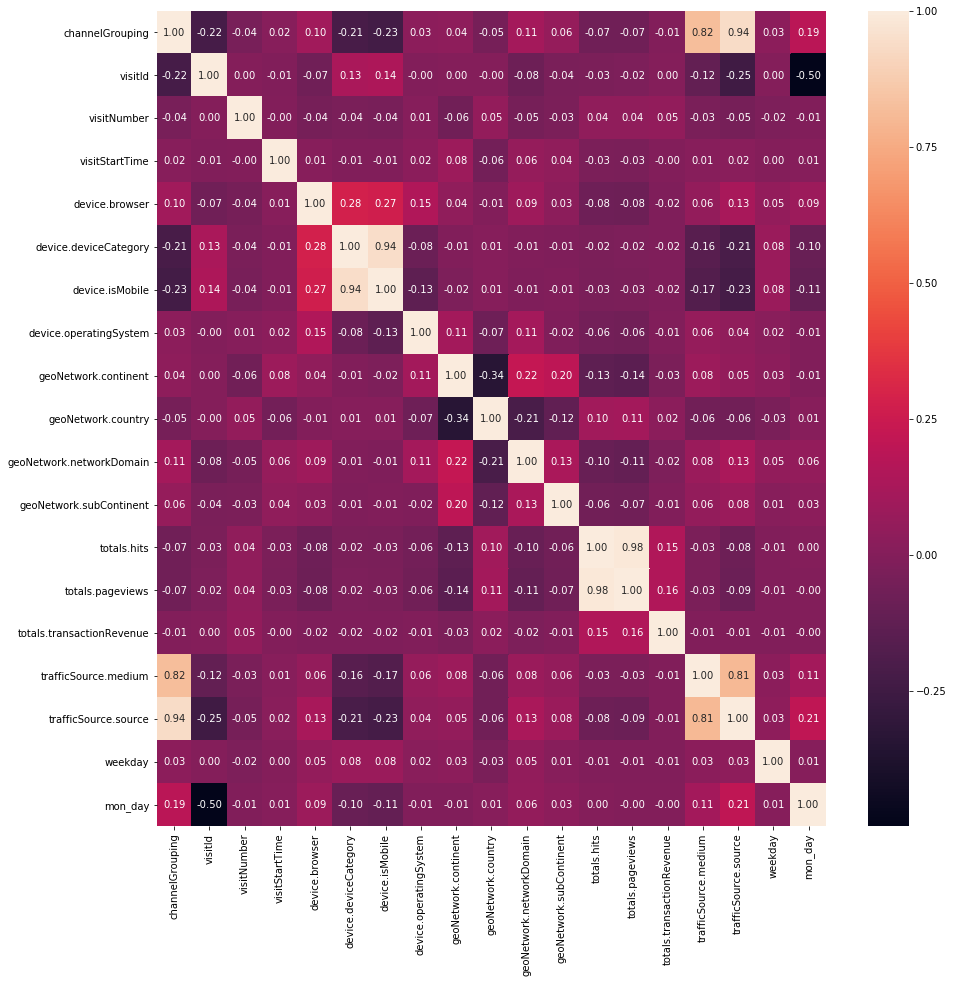

In [10]:
train = train.drop(columns=['totals.newVisits'])
test = test.drop(columns=['totals.newVisits'])
correlation = train.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, annot=True, annot_kws={"size": 10}, fmt='.2f')
plt.savefig('./Output/Pearson correlation.png')
plt.show()

Drop features: 
* 'trafficSource.medium', 'trafficSource.source' strongly correlate with 'channelGrouping' 
* 'device.isMobile' strongly correlates with 'device.deviceCategory'
* 'totals.hits' strongly correlates with 'totals.pageviews'

In [11]:
feature_cols = ['channelGrouping', 'visitNumber', 'visitStartTime', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.networkDomain', 'geoNetwork.subContinent', 'totals.pageviews', 'weekday', 'mon_day']
print('{} features will be used for model training, including: \n{}'.format(len(feature_cols), feature_cols))

13 features will be used for model training, including: 
['channelGrouping', 'visitNumber', 'visitStartTime', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.networkDomain', 'geoNetwork.subContinent', 'totals.pageviews', 'weekday', 'mon_day']


In [12]:
X_train = train[feature_cols]
X_test = test[feature_cols]
y_train = train['totals.transactionRevenue'].apply(lambda x: np.log(x) if x> 0 else 0)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, random_state=0)

## Baseline Model Selection
* Model1 : Linear Regression
* Model2 : Lasso (L1) 
* Model3 : Ridge (L2) 
* Model4 : K-NearestNeighbors 
* Model5 : Decision Tree
* Model6 : Random Forest
* Model7 : Gradient Boosting

In [13]:
Mod_Summary = pd.DataFrame(columns = ['Model Type','Training Score','Validation Score', 'RMSE'])
def eval(model, X_train1, y_train1, X_val, y_val, Mod_Summary):
    model = model.fit(X_train1,y_train1)
    pred_val = model.predict(X_val)
    TS = model.score(X_train1, y_train1)
    VS = model.score(X_val, y_val)
    val_rmse=round(np.sqrt(metrics.mean_squared_error(y_val, pred_val)),5)
    Mod_Summary = Mod_Summary.append({'Model Type':str(model).split('(')[0],'Training Score': TS,
                                      'Validation Score':VS,'RMSE':val_rmse}, ignore_index=True)
    return Mod_Summary


for model in [LinearRegression(), Lasso(), Ridge(), KNeighborsRegressor(),DecisionTreeRegressor(),
              RandomForestRegressor(), GradientBoostingRegressor()]:
    Mod_Summary = eval(model,X_train1, y_train1, X_val, y_val, Mod_Summary)
Mod_Summary.to_csv('./Output/Baseline model selection.csv')
Mod_Summary

,Model Type,Training Score,Validation Score,RMSE
0,LinearRegression,0.162140,0.172594,1.83698
1,Lasso,0.009378,0.010082,2.00930
2,Ridge,0.162140,0.172594,1.83698
3,KNeighborsRegressor,0.397141,0.108303,1.90701
4,DecisionTreeRegressor,0.998716,-0.401312,2.39063
5,RandomForestRegressor,0.855042,0.206139,1.79935
6,GradientBoostingRegressor,0.301720,0.313311,1.67349


#### Baseline Model Selected - Gradient Boosting Regressor
* DecisionTree model has overfitting issue, resulting in the highest RMSE
* GradientBoosting model showed lowest RMSE out of the 7 selected models